In [10]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
#torch.multiprocessing.set_start_method("spawn")
import pre_resnet
import resnet
from sklearn.model_selection import KFold

import os
import numpy as np
import pandas as pd
from utils import progress_bar
from skimage import transform as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
test = pd.read_json(BASE_dir + 'test.json')

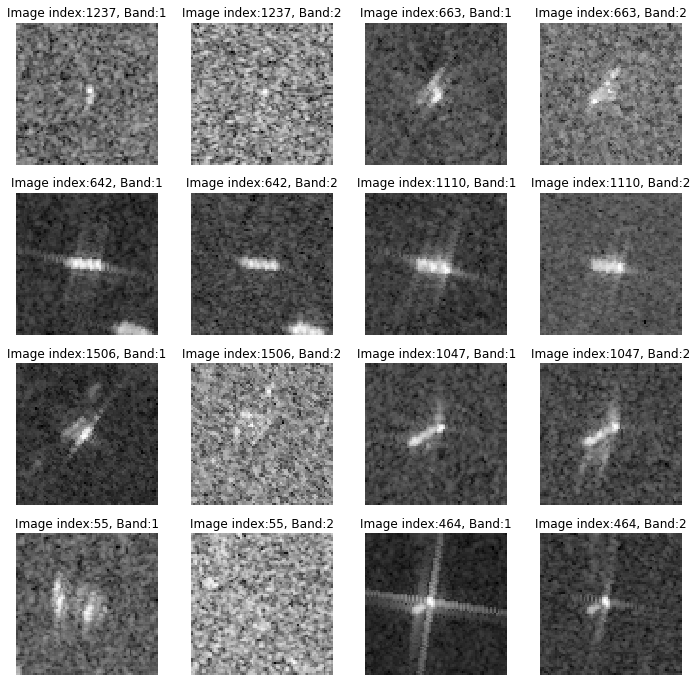

In [3]:
len(train) # 1604 obs
train.head(3)
#randomly draw some of them

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4,4)

index = np.random.choice(list(range(len(train))),size=8, replace=False)
for num,i in enumerate(index):
    for j in range(2):
        ax = plt.subplot(gs[num*2+j])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('Image index:%d, Band:%d' % (i, j%2+1))
        ax.set_aspect('equal')
        plt.imshow(np.array(train.iloc[i,j%2]).reshape(75,75))

In [14]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
#use_cuda =False
#dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
dtype = torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data, label, transform=None, test=False): #data: 1604 * 3 *75* 75
        self.data =data
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
        self.test= test
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label=  self.data[idx], self.label[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            
            #rotate, scale, shear, translation
#             if self.test is False:
#                 angle = np.random.uniform(0,360)
#                 img = tf.rotate(img,angle=angle,resize=False)
#                 scale1 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 scale2 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 #shear = np.random.uniform(-np.pi/18, np.pi/18)
#                 #tran = np.random.uniform(-5, 5)
#                 #aug = tf.AffineTransform(shear = shear, translation=tran, scale= (scale1, scale2))
#                 aug = tf.AffineTransform(scale= (scale1, scale2))
#                 img = tf.warp(img, inverse_map=aug)
            
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=1).copy()
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=2).copy()
            
            if self.test is False:
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=1).copy()
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=2).copy()
#                 rotate = np.random.randint(4, size=1)
#                 #scale = np.exp(np.random.uniform(np.log(1/1.1), np.log(1.1)))
#                 #aug = tf.AffineTransform(scale= (scale, scale))
#                 #img = tf.warp(img, inverse_map=aug)
#                 if rotate:
#                     img = np.rot90(img,k=rotate,axes=(1,2)).copy()
                pass
#             temp = []
#             for i in img:
#                 temp.append(tf.rescale(i,224/75,mode='constant'))
#             img = np.stack(temp)
            img = torch.from_numpy(img).type(dtype)
            img = self.transform(img)

        return img, label

def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
#     data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

def data_aug(X, y):    
    X_rot_30 = []
    X_rot_60 = [] 
    X_h = np.flip(X, 3)
    X_v = np.flip(X, 2)
    for i in X:
        X_rot_30.append(tf.rotate(i,angle=90,resize=False))
        X_rot_60.append(tf.rotate(i,angle=270,resize=False))
        
    X_rot_30 = np.stack(X_rot_30)
    X_rot_60 = np.stack(X_rot_60)
    ch_y = np.concatenate((y,y,y,y,y))
    ch_X = np.concatenate((X, X_h, X_v, X_rot_30, X_rot_60))
    return ch_X, ch_y


def data_aug2(X, y):    
    X_rot_90 = []
    X_rot_180 = []
    X_rot_270 = []
    X_rot_90_hflip = []
    X_rot_270_hflip = []
    
    X_h = np.flip(X, 3)
    X_v = np.flip(X, 2)
    for i in X:
        X_rot_90.append(tf.rotate(i,angle=90,resize=False))
        X_rot_180.append(tf.rotate(i,angle=180,resize=False))
        X_rot_270.append(tf.rotate(i,angle=270,resize=False))
        X_rot_90_hflip.append(np.flip(tf.rotate(i,angle=90,resize=False),2))
        X_rot_270_hflip.append(np.flip(tf.rotate(i,angle=270,resize=False),2))
    
    
    X_rot_90 = np.stack(X_rot_90)
    X_rot_180 = np.stack(X_rot_180)
    X_rot_270 = np.stack(X_rot_270 )
    X_rot_90_hflip = np.stack(X_rot_90_hflip)
    X_rot_270_hflip = np.stack(X_rot_270_hflip)
    
    ch_y = np.concatenate((y,y,y,y,y,y,y,y))
    ch_X = np.concatenate((X, X_h, X_v,X_rot_90,X_rot_180,X_rot_270,X_rot_90_hflip,X_rot_270_hflip))
    return ch_X, ch_y


train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1

In [7]:
# #train_index=list(range(1300))
# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))
# #train_index=list(range(1444)) 
# #val_index= list(range(1444,1604))

# # train_X[train_index].shape

# train_mean, train_std = transform_compute(train_X[train_index])
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])

# train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)


train_X_del = train_X
train_y_del = train_y

In [6]:
torch.cuda.is_available()
torch.from_numpy(train_X).type(torch.FloatTensor)[1].shape
train_X[1]
use_cuda

True

In [8]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        scheduler.step()
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >=best_acc:
                best_acc= acc
                e_s = 0
                torch.save(net.state_dict(), 'resnet18.pth')
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if i %80 ==0:
            torch.save(net.state_dict(), 'resnet18-80epoch.pth')
        if early_stopping is not None and e_s >= early_stopping:
            return best_acc,i

    return best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

In [13]:
# resnet18 = resnet.resnet18(num_classes=2)
net= resnet18
#net.load_state_dict(torch.load('resnet101.pth'))

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0015, nesterov= True)
scheduler = MultiStepLR(optimizer, [80, 120, 160], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=200)


This is epoch:1
[=================== 41/41 =================>.]  Step: 17ms | Tot: 1s785ms | Loss: 0.485 | Acc: 77.163% (990/1283)
[=================== 6/6 =============>.......]  Step: 7ms | Tot: 106ms | Loss: 1.274 | Acc: 54.206% (174/321)

This is epoch:2
[=================== 41/41 =================>.]  Step: 17ms | Tot: 1s780ms | Loss: 0.443 | Acc: 80.670% (1035/1283)
[=================== 6/6 =============>.......]  Step: 7ms | Tot: 106ms | Loss: 0.542 | Acc: 74.143% (238/321)

This is epoch:3
[=================== 41/41 =================>.]  Step: 18ms | Tot: 1s789ms | Loss: 0.474 | Acc: 77.553% (995/1283)
[=================== 6/6 =============>.......]  Step: 8ms | Tot: 108ms | Loss: 0.688 | Acc: 63.863% (205/321))

This is epoch:4
[=================== 41/41 =================>.]  Step: 18ms | Tot: 1s783ms | Loss: 0.566 | Acc: 72.798% (934/1283)
[=================== 6/6 =============>.......]  Step: 7ms | Tot: 105ms | Loss: 0.537 | Acc: 74.143% (238/321)

This is epoch:5
[========

[=================== 41/41 =================>.]  Step: 18ms | Tot: 1s779ms | Loss: 0.419 | Acc: 81.839% (1050/1283)
[=================== 6/6 =============>.......]  Step: 7ms | Tot: 106ms | Loss: 0.506 | Acc: 77.570% (249/321)

This is epoch:68
[=================== 41/41 =================>.]  Step: 17ms | Tot: 1s777ms | Loss: 0.443 | Acc: 80.359% (1031/1283)
[=================== 6/6 =============>.......]  Step: 7ms | Tot: 104ms | Loss: 0.523 | Acc: 76.636% (246/321)

This is epoch:69
[=================== 41/41 =================>.]  Step: 17ms | Tot: 1s776ms | Loss: 0.401 | Acc: 82.151% (1054/1283)
[=================== 6/6 =============>.......]  Step: 7ms | Tot: 105ms | Loss: 0.458 | Acc: 80.374% (258/321)

This is epoch:70
[=================== 41/41 =================>.]  Step: 17ms | Tot: 1s781ms | Loss: 0.412 | Acc: 81.450% (1045/1283)
[=================== 6/6 =============>.......]  Step: 7ms | Tot: 105ms | Loss: 0.733 | Acc: 60.748% (195/321)

This is epoch:71
[===================

[=================== 41/41 =================>.]  Step: 17ms | Tot: 1s772ms | Loss: 0.292 | Acc: 87.373% (1121/1283)
[=================== 6/6 =============>.......]  Step: 8ms | Tot: 106ms | Loss: 0.321 | Acc: 85.358% (274/321)

This is epoch:134
[=================== 41/41 =================>.]  Step: 17ms | Tot: 1s796ms | Loss: 0.289 | Acc: 87.997% (1129/1283)
[=================== 6/6 =============>.......]  Step: 7ms | Tot: 104ms | Loss: 0.312 | Acc: 87.227% (280/321)

This is epoch:135
[=================== 41/41 =================>.]  Step: 17ms | Tot: 1s815ms | Loss: 0.280 | Acc: 87.919% (1128/1283)
[=================== 6/6 =============>.......]  Step: 8ms | Tot: 105ms | Loss: 0.312 | Acc: 87.539% (281/321)

This is epoch:136
[=================== 41/41 =================>.]  Step: 17ms | Tot: 1s795ms | Loss: 0.288 | Acc: 88.542% (1136/1283)
[=================== 6/6 =============>.......]  Step: 7ms | Tot: 105ms | Loss: 0.310 | Acc: 85.981% (276/321)

This is epoch:137
[===============

[=================== 41/41 =================>.]  Step: 17ms | Tot: 1s783ms | Loss: 0.272 | Acc: 88.465% (1135/1283)
[=================== 6/6 =============>.......]  Step: 7ms | Tot: 104ms | Loss: 0.305 | Acc: 86.916% (279/321)

This is epoch:200
[=================== 41/41 =================>.]  Step: 17ms | Tot: 1s770ms | Loss: 0.273 | Acc: 88.387% (1134/1283)
[=================== 6/6 =============>.......]  Step: 7ms | Tot: 107ms | Loss: 0.309 | Acc: 86.604% (278/321)


(87.53894080996885, 199)

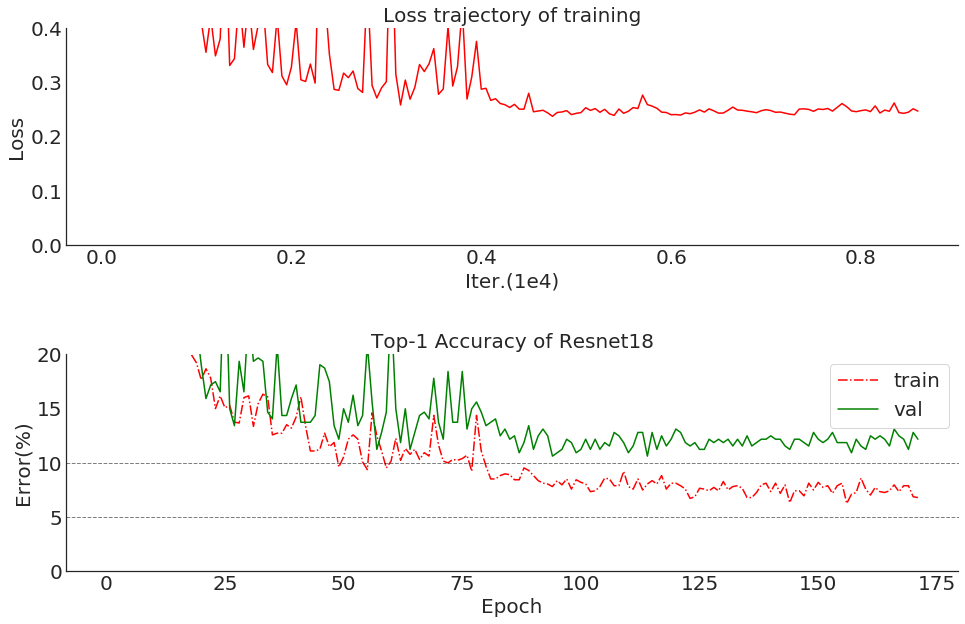

In [10]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.4))

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet18',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

In [18]:
out1 = torch.cat((out.data,out.data),1)
out1.size()
# out
criterion(out,y.long())
type(predicted)
type(y.data)
#predicted.eq(y.data).cpu().sum()

torch.cuda.DoubleTensor

In [40]:
net = resnet.resnet18(num_classes=2)
net.load_state_dict(torch.load('resnet18.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    temp = np.exp(out.cpu().data.numpy())
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))

[=================== 132/132 ================>]  Step: 88ms | Tot: 15s83msms


In [41]:
np.concatenate(prob).shape

(8424,)

In [22]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step()
        scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'resnet18_acc.pth')
            if val_loss <best_val_loss and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                e_s = 0
                acc= best_acc+ 0.01
                print('loss: Save it!')
                torch.save(net.state_dict(), 'resnet18_loss.pth')
            if loss_avg/total > val_loss:
                e_s = 0
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,i

    return best_val_loss, best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

#Try different transformation

result_hist =[]
ran_num = 5555
seed= np.random.RandomState(ran_num)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
rou=0
for k,(train_index, val_index) in enumerate(spliter.split(train_X_del)):

    train_mean, train_std = transform_compute(train_X_del[train_index])
    train_transform = T.Compose([
        T.Normalize(train_mean, train_std)
    ])
    af_train_X, af_train_y = data_aug(train_X_del[train_index], train_y_del[train_index])

    train_dataset = iceberg_dataset(data= af_train_X, label=af_train_y, transform=train_transform)
    val_dataset = iceberg_dataset(data= train_X_del[val_index], label=train_y_del[val_index], transform=train_transform, test=True)

    train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                              shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

    candidate = []
    for rep in range(1):
        net18 = resnet.resnet18(num_classes=2,dropout=[0.2,0.2,0.5,0.7])
        net= net18

        criterion = nn.CrossEntropyLoss()

        optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0002, nesterov= True)
        scheduler = ReduceLROnPlateau(optimizer, 'max', patience =10,min_lr= 0.0001)
        #5e-3 86
        if use_cuda:
            criterion.cuda()
            net.cuda()
        
        result = train(epoch=250,early_stopping= 20)
        result_hist.append(result[0])
        candidate.append(result[0])
        with open("test_resnet/log.txt", "a") as myfile:
            msg = '18: At fold {}, seed {},round {} we find one with acc: {}, loss: {}\n'.format(
                                                        k,ran_num,rep+1, result[1], result[0])
            myfile.write(msg)
        cmd = 'cp resnet18_loss.pth resnet18_loss{}.pth'.format(rep)
        os.system(cmd)
        if len(candidate)==2:
            if np.sum(np.array(candidate)<0.18)>=1:
                continue
            else:
                break
#         if min(candidate)>0.195:
#             with open("fcn_models/log.txt", "a") as myfile:
#                 msg = 'We are going to give up this round\n'
#                 myfile.write(msg)
#             continue

    #actually an array
    #final_list = np.union1d(np.where(np.array(candidate) <0.185)[0], [candidate.index(min(candidate))])
    final_list = range(len(candidate))
    word= ''
    for i in np.array(candidate)[final_list]:
        word = word +', '+ str(i)


    for g in final_list:
        with open("test_resnet/result.txt", "a") as myfile:
            msg = '18: At fold {}, seed {},round {} we find {} with loss: {}\n'.format(
                                                        k,ran_num,rep+1, len(final_list), word)
            myfile.write(msg)
        cmd = 'cp resnet18_loss{}.pth test_resnet/resnet18{}_{}{}.pth'.format(g,rou,k,g)
        os.system(cmd)


This is epoch:1
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 2.330 | Acc: 50.242% (3223/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.806 | Acc: 50.779% (163/321)
acc: Save it!

This is epoch:2
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 2.704 | Acc: 49.712% (3189/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.692 | Acc: 53.583% (172/321)
acc: Save it!

This is epoch:3
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 2.478 | Acc: 50.304% (3227/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.836 | Acc: 50.779% (163/321)

This is epoch:4
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 1.913 | Acc: 50.039% (3210/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.704 | Acc: 49.221% (158/321)

This is epoch:5
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 1.731 | Acc: 50.210% (3221/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.694 | Acc: 50.779% (163/321)

This is epoch:6
[=========

[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.386 | Acc: 81.620% (262/321)

This is epoch:43
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.515 | Acc: 70.990% (4554/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.377 | Acc: 84.424% (271/321)
acc: Save it!

This is epoch:44
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.516 | Acc: 69.945% (4487/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.461 | Acc: 78.505% (252/321)

This is epoch:45
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.501 | Acc: 71.754% (4603/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.544 | Acc: 75.078% (241/321)
loss: Save it!

This is epoch:46
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.504 | Acc: 71.193% (4567/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.416 | Acc: 81.620% (262/321)

This is epoch:47
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.505 | Acc: 71.052% (4558/6415)
[=========   6/  6 ==

[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.236 | Acc: 89.720% (288/321)
acc: Save it!

This is epoch:85
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.347 | Acc: 83.632% (5365/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.854 | Acc: 44.548% (143/321)

This is epoch:86
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.406 | Acc: 80.857% (5187/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.271 | Acc: 88.162% (283/321)

This is epoch:87
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.361 | Acc: 82.432% (5288/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.245 | Acc: 90.966% (292/321)
acc: Save it!

This is epoch:88
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.354 | Acc: 83.055% (5328/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.240 | Acc: 90.343% (290/321)

This is epoch:89
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.349 | Acc: 83.757% (5373/6415)
[=========   6/  6 ==>

[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.236 | Acc: 90.343% (290/321)

This is epoch:127
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.255 | Acc: 88.901% (5703/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.247 | Acc: 89.408% (287/321)

This is epoch:128
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.256 | Acc: 88.683% (5689/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.240 | Acc: 89.720% (288/321)

This is epoch:129
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.247 | Acc: 88.995% (5709/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.250 | Acc: 89.720% (288/321)
loss: Save it!

This is epoch:130
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.264 | Acc: 88.200% (5658/6415)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.247 | Acc: 88.785% (285/321)

This is epoch:131
[========= 101/101 ======>]Step: 0ms| Tot: 7s1ms|Loss: 0.262 | Acc: 88.309% (5665/6415)
[=========   6/  6 ==>....]Ste

Process Process-4266:
Process Process-4265:
Process Process-4264:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/

KeyboardInterrupt: 

In [42]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = np.concatenate(prob)
sub.shape
sub.to_csv('submission2.csv',index=False)